<a href="https://colab.research.google.com/github/ammobam/Display_SensorData/blob/main/210804_PCA_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기
* 결측치처리 완료
* 상관계수 0.9 이상인 컬럼 삭제 완료
* VIF 값이 30 이하가 될 때까지 컬럼 삭제 완료
    * 삭제 방법 : VIF 연산 > 가장 높은 VIF값이 30 이상이면 그 컬럼 삭제 > VIF 연산 반복
* 할 일
    * right 컬럼 지우기
    * 스케일링
    * PCA 수행
    * 나온 2개 값으로 산포도 그려보기
    * 설명변수 비율 뽑아서 가장 큰 피처들 2개로 산포도 그려서 비교해볼까?

In [4]:
# 데이터 불러오기 - VIF 값이 30 이하가 될때가지 컬럼을 삭제하며 반복 수행한 결과 (179개 컬럼)
#import pandas as pd
origin_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/1. 데이터_디스플레이/factory_glass_2016.zip', encoding='cp949')
origin_data = origin_data.set_index('dat...date.name.', drop=True)

print(len(origin_data.columns))
origin_data.columns
origin_data.head()
# 레이블 : 'L.RD', 'L.Vac', 'R.RD', 'R.Vac'

840


,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,...,S_C1_C2_L_L,S_C1_C2_L_R,S_C2_C3_U_L,S_C2_C3_U_R,S_C2_C3_L_L,S_C2_C3_L_R,S_C3_C4_U_L,S_C3_C4_U_R,S_C3_C4_L_L,S_C3_C4_L_R,S_AB1_AB11_L,S_AB1_AB11_R,S_AB11_AB7_L,S_AB11_AB7_R,S_AB7_C4_L,S_AB7_C4_R,S_C4_RET_L,S_C4_RET_R,S_RET_F_L,S_RET_F_R,STD_U_L,STD_U_R,STD_L_L,STD_L_R,STD_GLS_L,STD_GLS_R,투입.LEFT.,투입.RIGHT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.195736,0.706941,1.477203,0.410847,0.491620,0.942180,2.776941,2.492437,2.060406,2.612283,1.726404,1.461145,-1.192642,-1.134471,2.599429,2.690433,-0.365598,-0.659319,-1.963403,-1.621407,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,80,74,2,5,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.500742,0.822657,1.495204,0.397591,0.587871,0.938186,2.888919,2.573187,2.161149,2.664726,1.682081,1.414518,-1.109125,-1.042269,2.588703,2.654307,-0.348979,-0.560103,-1.978936,-1.810022,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,92,75,0,2,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,-1.8189,-1.548119,-1.779407,-1.548119,-1.779407,-1.548119,-1.806012,-1.548119,-1.775051,-1.548119,-1.776634,-1.548119,-1.766604,-1.548119,-1.775051,-1.638207,-1.728206,-1.674911,-1.641818,-1.662151,-1.636293,-1.622314,-1.653428,-1.548119,-1.807954,-1.73,-1.315444,-1.620631,-1.517655,-1.804912,...,-0.164556,0.962210,1.552127,0.460702,0.397216,0.843443,2.868644,2.486441,2.183298,2.638130,1.632955,1.359022,-0.986580,-0.928583,2.550175,2.606185,-0.456071,-0.644073,-1.878611,-1.742395,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,64,66,1,4,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.713219,-

In [5]:
# 데이터 불러오기 - VIF 값이 30 이하가 될때가지 컬럼을 삭제하며 반복 수행한 결과 (179개 컬럼)
#import pandas as pd
fact_data = pd.read_csv('/content/drive/MyDrive/나무플래닛/3. 산출물/0804 VIF 수행후 컬럼삭제_Right 컬럼 포함됨/fact_data_vif.csv')
fact_data = fact_data.set_index('dat...date.name.', drop=True)

print(len(fact_data.columns))
fact_data.columns

179


Index(['X1WOS45106_PV', 'X1WOS45107_PV', 'X1WOS45109_PV',
       'DCS_Offset_RPM_M11.1WOS45111_PV', 'DCS_Offset_RPM_M15.1WOS45115_PV',
       'DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV', 'N2.TO.EA1313A.1FI33503A_PV',
       'ROOF.HEATING.Zone.1.1JIC31101.PV', 'ROOF.HEATING.Zone.2.1JIC31102.PV',
       'ROOF.HEATING.Zone.3.1JIC31103.PV',
       ...
       'S_C1_C2_L_L', 'S_C2_C3_U_R', 'S_C3_C4_U_L', '투입.LEFT.',
       'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.', 'ROLLDOWN.폐기.RIGHT.',
       '진공패드.폐기.RIGHT.', 'ROLLDOWN.진공패드.폐기율..LEFT.',
       'ROLLDOWN.진공패드.폐기율..RIGHT.'],
      dtype='object', length=179)

## PCA 수행하기 전 데이터 전처리

### Right 공정 컬럼 제외

In [6]:
# 컬럼명 분류 딕셔너리 파일 불러오기
import pickle

# load data
with open('/content/drive/MyDrive/나무플래닛/3. 산출물/dict_left_right.pickle', 'rb') as fr:
    dict_l_r = pickle.load(fr)

In [7]:
# Right 공정 컬럼명만 리스트로 만들기
print(dict_l_r.keys())
print(type(dict_l_r['Right']))
col_right = dict_l_r['Right']

dict_keys(['Left', 'Right', 'Center'])
<class 'list'>


In [8]:
# 전체 컬럼에서 right 공정 컬럼을 제외한 컬럼명 리스트 만들기

col_use = []

# 데이터의 전체 컬럼에 대해서
for col in fact_data.columns:
    # 만약 컬럼이 right 생산공정에 포함되지 않는다면
    if col not in col_right:
        # 그 컬럼을 col_use 리스트에 추가할 것
        col_use.append(col)

print(len(col_use))
# 179 -> 150개로 줄어들음

150


In [9]:
# 데이터프레임 저장
fact_data_150 = fact_data[col_use]
# 확인
fact_data_150.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 150 entries, X1WOS45106_PV to ROLLDOWN.진공패드.폐기율..LEFT.
dtypes: float64(150)
memory usage: 9.4+ MB


In [10]:
# 레이블 컬럼이 쓸 컬럼목록에 있는지 확인
col_label = ['L.RD', 'L.Vac', 'R.RD', 'R.Vac']
for col in col_label:
    if col in col_use:
        print("확인", col)
# 없음

### 컬럼 확인

In [11]:
# 모든 행에 대해 같은 값을 갖는 컬럼이 있는지 확인
all_value_same_col=[]
for i in range(len(fact_data_150.columns)):
    if min(fact_data_150.iloc[:, i]) == max(fact_data_150.iloc[:, i]):
        print(i)
        all_value_same_col.append(i)
if len(all_value_same_col)==0:
    print("모든 행에 대해 같은 값을 갖는 컬럼은 없습니다")

모든 행에 대해 같은 값을 갖는 컬럼은 없습니다


In [12]:
fact_data_150.describe()

,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.C2..Z175.TMP.1TIC42307.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M10.2.CUR.1WII40117.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,TMP.TIN..BAY.1.LEFT.1TI30201.PV,...,bay6_7,l_r_tin_bay10,lc_rc_btm_dn,c_btm_up_dn,l_r_top_n.1,top_1,top_5,D_AB1_L_LR,D_AB2_L_LR,D_AB3_L_LR,D_AB4_U_LR,D_AB5_U_LR,D_AB9_L_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB7_L_UL,D_AB8_L_UL,D_C1_U_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB4_AB5_U_L,S_AB6_AB7_L_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C3_C4_U_L,투입.LEFT.,ROLLDOWN.폐기.LEFT.,진공패드.폐기.LEFT.,ROLLDOWN.진공패드.폐기율..LEFT.
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.002465,0.000362,0.000672,0.000096,0.000519,-0.000462,-0.000374,0.000010,-0.000065,-0.000015,0.000020,-0.002179,0.000004,-0.000196,0.000248,0.000088,0.000015,-0.000738,-0.000007,-0.000013,-0.000010,0.000115,-0.000010,0.000586,-0.001312,0.000114,-0.000012,0.000059,0.000470,...,-0.000104,0.001108,0.001127,0.000704,0.000652,-0.000388,0.001061,-0.000284,0.000130,0.000162,0.000249,0.000042,-0.000222,0.000974,0.001102,0.001712,-0.000169,-0.000120,-0.000605,0.000553,0.000667,0.000614,-0.000795,0.000196,0.001651,0.000196,0.001021,-0.000788,-0.000435,0.000490,0.000043,0.000203,0.000325,-0.000536,-0.000530,0.000242,93.602210,1.562799,1.754451,3.720192
std,1.000423,1.000427,1.000427,1.000420,1.000407,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,0.996887,1.000346,1.000141,1.000423,1.000272,1.000305,1.000348,1.000430,1.000427,1.000430,1.000429,0.996634,1.000430,1.000407,1.000394,1.000425,1.000430,1.000113,1.000430,1.000430,1.000430,1.000422,1.000430,1.000229,0.999675,1.000360,1.000368,1.000366,1.000301,...,1.000423,0.999713,0.999690,1.000140,1.000182,1.000266,0.999774,1.000382,1.000420,1.000414,1.000393,1.000427,1.000400,0.999875,0.999720,0.998717,1.000411,1.00042

In [13]:
fact_data_150.iloc[:, 1].describe()

count    8145.000000
mean       -0.000066
std         1.000427
min       -12.992791
25%         0.076956
50%         0.076956
75%         0.076956
max         0.076956
Name: X1WOS45107_PV, dtype: float64

### ■ fact_data_150 : 레이블 추가 안 된 데이터

* 데이터 프레임 합치기 : pd.merge와 pd.concat의 차이
* 참고링크 : https://yganalyst.github.io/data_handling/Pd_12/#1-1-pdconcat%EC%9D%98-%EC%98%B5%EC%85%98

## ■ fact_data_152 : 레이블 두개 추가된 데이터

In [14]:
# 레이블 데이터 확인
col_label = ['L.RD', 'L.Vac']   # 'R.RD', 'R.Vac'

origin_data[col_label].info()
print(origin_data[col_label].head())
# 결측치 없는 8145개 행. 그대로 합쳐서 사용하면 됨.

# 레이블 데이터 합치기
fact_data_152 = pd.concat([fact_data_150, origin_data[col_label]], axis=1)

# 확인
print(fact_data_152.shape)
# 만약 여기서 행 개수가 8145개를 넘으면 concat할 때 두 데이터프레임의 인덱스가 달라서 달리 합쳐진 것일 수 있음
# df_origin 불러올 때 인덱스 설정을 동일하게 해주자
# 혹은 fact_data_152['레이블 이름']으로 추가할 수 있음

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   L.RD    8145 non-null   float64
 1   L.Vac   8145 non-null   float64
dtypes: float64(2)
memory usage: 190.9+ KB
                   L.RD  L.Vac
dat...date.name.              
2016-01-01 07     0.025  0.063
2016-01-01 08     0.000  0.022
2016-01-01 09     0.016  0.063
2016-01-01 10     0.000  0.103
2016-01-01 11     0.000  0.000
(8145, 152)


### 레이블 데이터 합치기
- 주의할 점 : 레이블 컬럼이 현재 빠져있으니 추가하여 스케일링 진행해야 함

In [15]:
# 모든 행에 대해 0~1 사이의 값을 넘는 컬럼이 있는지 확인
scale_needcol = []

# 전체 컬럼에 대해서
for i in range(len(fact_data_150.columns)):
    # 각 컬럼의 최소값
    min_value = min(fact_data_150.iloc[:, i])
    # 각 컬럼의 최대값
    max_value = max(fact_data_150.iloc[:, i])
    # 최소값이 0보다 작거나, 최대값이 1보다 큰 경우는 스케일링이 필요한 컬럼임
    if min_value<0 or max_value>1:
        scale_needcol.append(i)

# 스케일링이 필요한 컬럼 수 확인
print(len(scale_needcol))

150


## PCA 수행

#### 스케일링 수행
* StandardScaler는 이상치의 영향을 크게 받아서 데이터 범위가 커질 수 있음

스케일링한 데이터 최소값: -90.24411338142781
스케일링한 데이터 최대값: 90.24411338142784


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-9.02441134e+01, -7.21952907e+01, -5.41464680e+01, -3.60976454e+01,
        -1.80488227e+01,  1.42108547e-14,  1.80488227e+01,  3.60976454e+01,
         5.41464680e+01,  7.21952907e+01,  9.02441134e+01]),
 <a list of 152 Lists of Patches objects>)

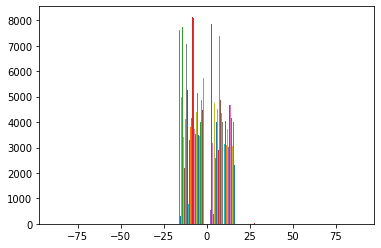

In [16]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(fact_data_152)
fact_data_152_scaled = scaler.transform(fact_data_152)

# 데이터 범위 확인
print("스케일링한 데이터 최소값:", fact_data_152_scaled.min())
print("스케일링한 데이터 최대값:", fact_data_152_scaled.max())

# 시각화
plt.hist(fact_data_152_scaled)
# 중앙에만 데이터가 분포되어 있음. 다른 스케일링 기법을 사용하는 것이 적절함

스케일링한 데이터 최소값: 0.0
스케일링한 데이터 최대값: 1.0000000000000002


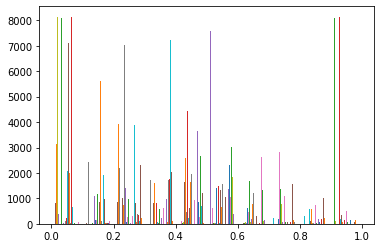

In [17]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(fact_data_152)
fact_data_152_scaled = scaler.transform(fact_data_152)


# 데이터 범위 확인
print("스케일링한 데이터 최소값:", fact_data_152_scaled.min())
print("스케일링한 데이터 최대값:", fact_data_152_scaled.max())

# 시각화
plt.hist(fact_data_152_scaled)
plt.show()

# 값이 0과 1 사이에 고루 분포하여 비교하기 쉬운 MinMax 스케일링 선택

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


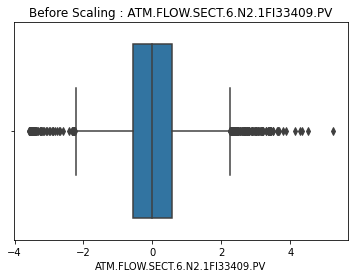

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


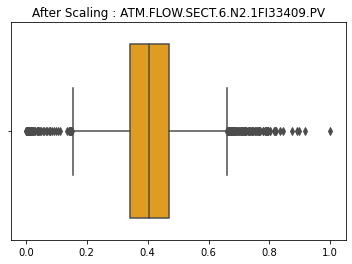

In [18]:
# 스케일링 전, 후 데이터 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(fact_data_152.iloc[:,95])
plt.title("Before Scaling : " + fact_data_152.iloc[:,95].name)
plt.show()
sns.boxplot(fact_data_152_scaled[:,95], color = 'orange')
plt.title("After Scaling : " + fact_data_152.iloc[:,95].name)

plt.show()

### PCA 수행
* 참고 링크 : https://excelsior-cjh.tistory.com/167

In [19]:
# PCA 수행
from sklearn.decomposition import PCA
pca = PCA(n_components=152)

# fit() 과 transform()을 호출해 PCA 변환 데이터 리턴
pca.fit(fact_data_152_scaled)
fact_data_pca = pca.transform(fact_data_152_scaled)

# PCA 수행 후 데이터 확인
print(fact_data_pca.shape)

# 설명변수
print(pca.explained_variance_[:4])
# 설명변수 비율
print(pca.explained_variance_ratio_[:4])
# 주성분 행렬
print('singular value :', pca.singular_values_[:4])

(8145, 152)
[0.72018523 0.35882667 0.28401128 0.17132138]
[0.25115073 0.12513389 0.09904346 0.05974503]
singular value : [76.58451897 54.05815784 48.09353245 37.35292968]


In [20]:
# PCA 수행 결과를 데이터프레임으로 만들어서 확인

# 컬럼이름 붙이기
pca_columns_name = [f"pca{num+1}" for num in range(fact_data_152.shape[1])]
# 데이터프레임 만들기
pca_df = pd.DataFrame(fact_data_pca, columns = pca_columns_name, index=fact_data_152.index)
pca_df.info()
pca_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8145 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 152 entries, pca1 to pca152
dtypes: float64(152)
memory usage: 9.5+ MB


,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,...,pca113,pca114,pca115,pca116,pca117,pca118,pca119,pca120,pca121,pca122,pca123,pca124,pca125,pca126,pca127,pca128,pca129,pca130,pca131,pca132,pca133,pca134,pca135,pca136,pca137,pca138,pca139,pca140,pca141,pca142,pca143,pca144,pca145,pca146,pca147,pca148,pca149,pca150,pca151,pca152
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,1.921118,0.033123,1.069643,-1.093703,0.269825,-0.027268,0.062036,-0.055473,0.195291,-0.418511,0.575197,-0.494005,-0.364110,-0.601116,0.183391,-0.221168,0.539349,-0.180129,0.105806,-0.183853,0.011723,0.161098,-0.175916,-0.089420,-0.042815,0.380981,0.084484,-0.004903,0.108552,0.249352,-0.088088,-0.456156,0.221972,0.354068,0.083689,0.062983,0.140180,0.046374,-0.192404,-0.197631,...,0.053754,-0.002870,0.008241,-0.015091,0.008559,0.037739,-0.029012,-0.028248,-0.005219,-0.001324,0.019484,0.032920,-0.013331,0.035926,-0.005358,-0.001286,-0.000736,-0.005722,0.039208,-0.004905,0.004348,0.014820,-0.002301,-0.002302,-0.008487,0.000224,-0.003393,0.003564,-0.001167,-0.005944,-0.060846,0.000473,0.002038,0.009671,0.004849,-0.003389,0.005245,-0.000046,-0.000117,-0.000442
2016-01-01 08,1.873661,0.023954,1.016702,-1.127384,0.250729,-0.074598,0.073198,-0.062419,0.150592,-0.452658,0.563945,-0.550923,-0.303465,-0.572122,0.135685,-0.168702,0.516875,-0.182132,0.212237,-0.129906,0.035933,0.096119,-0.171016,-0.052616,-0.079815,0.292464,0.076538,0.058852,0.078314,0.209993,-0.007387,-0.266906,0.261194,0.264419,-0.006373,0.014985,0.101814,0.058079,-0.064251,-0.171618,...,-0.008776,0.012518,0.016810,-0.000038,0.004940,0.037912,-0.029158,-0.041890,0.023240,-0.003756,-0.006474,0.008209,0.015787,0.007619,0.000378,-0.002987,0.004044,0.001826,0.012680,0.003992,0.010652,0.010342,-0.001745,0.001501,0.000070,-0.001133,0.001390,0.000210,0.000970,-0.004869,0.007213,-0.001962,-0.007391,0.007118,0.009205,-0.002235,0.004158,-0.000299,-0.003746,-0.000272
2016-01-01 09,1.934041,-0.000459,1.086781,-1.156094,0.251260,-0.052100,0.065468,-0.102313,0.191913,-0.400947,0.605391,-0.548709,-0.298996,-0.476071,0.222715,-0.226160,0.518767,-0.219193,-0.037510,-0.151928,-0.003776,0.122371,-0.114639,-0.141694,-0.119374,0.355947,0.038823,0.079321,0.144110,0.189467,0.060134,-0.234173,0.258078,0.386706,0.129005,0.038744,0.195149,0.007173,0.099210,-0.100696,...,-0.031525,0.050695,0.046024,-0.012891,0.039439,0.026963,-0.036708,0.000300,0.018166,0.005231,-0.009098,0.001546,0.007000,0.024539,-0.004138,-0.002760,0.003534,0.016182,0.017428,-0.001134,0.012089,0.012287,-0.001631,-0.002383,0.002380,-0.002202,0.001845,0.000693,0.000181,-0.006152,0.003016,-0.002877,-0.003972,0.004031,0.006859,-0.002343,0.001971,-0.000254,-0.000370,-0.000697
2016-01-01 10,1.947200,0.015678,1.082644,-1.123753,0.281445,-0.046572,0.088144,-0.071654,0.194809,-0.454810,0.539275,-0.564058,-0.306133,-0.528741,0.181238,-0.209429,0.579769,-0.226271,0.064004,-0.164099,-0.031651,0.201967,-0.109602,-0.076568,-0.052115,0.330364,0.146535,0.039734,0.187227,0.215885,0.076856,-0.298134,0.207416,0.350034,0.067459,0.037863,0.146264,0.018772,-0.167528,-0.167979,...,-0.000956,0.008131,0.008972,-0.014778,0.006903,0.044071,-0.017689,-0.031195,0.028154,-0.011002,-0.027652,0.018715,0.007807,0.033956,0.014086,-0.010264,0.001593,0.009272,0.014535,-0.002992,0.000061,0.004994,-0.000438,0.001428,0.006737,0.001517,0.002072,-0.002053,-0.004811,-0.002825,-0.003410,-0.003379,-0.003075,0.004386,0.011146,-0.002467,0.004023,0.000157,-0.000682,-0.000109
2016-01-01 11,2.026720,-0.003799,1.113286,-1.172820,0.283072,-0.017171,0.129884,-0.077704,0.172555,-0.369182,0.540923,-0.646212,-0.234979,-0.400560,0.328168,-0.351748,0.562834,-0.281808,-0.168287,-0.073910,-0.106099,0.161937,-0.058007,-0.177118,-0.033343,0.320233,0.058876,0.089097,0.09576

#### 적당한 n_components 개수 정하기

Text(0, 0.5, 'explained_variance_')

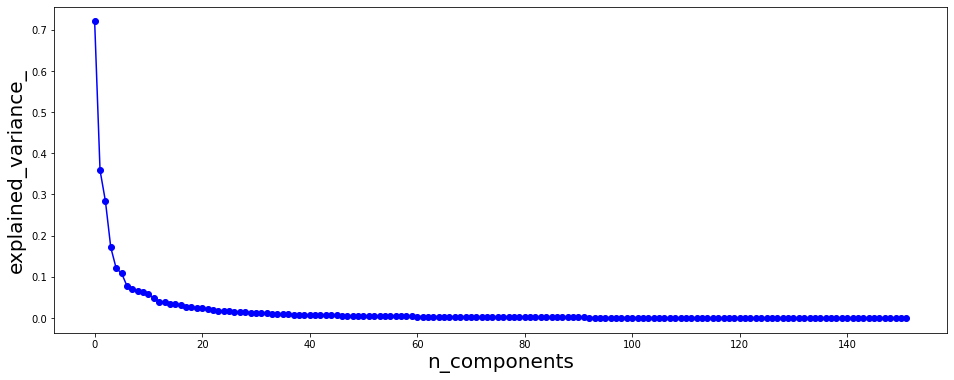

In [21]:
 # Scree Plot 그리기
 # x축 : n_components 수
 # y축 : 설명변수
 plt.figure(figsize=(16, 6))
 plt.plot(pca.explained_variance_, marker='o', c='blue')
 plt.xlabel("n_components", fontsize=20)
 plt.ylabel("explained_variance_", fontsize=20)
 # Elbow(그래프가 급격히 꺾이는 지점) 확인
 # n_components = 5 정도가 적당할 듯

In [22]:
# 데이터프레임으로 보기
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_, '기여율':pca.explained_variance_ratio_},
                      index=pca_columns_name)
result[:10]

,설명가능한 분산 비율(고윳값),기여율
pca1,0.720185,0.251151
pca2,0.358827,0.125134
pca3,0.284011,0.099043
pca4,0.171321,0.059745
pca5,0.120840,0.042141
pca6,0.108907,0.037979
pca7,0.078203,0.027272
pca8,0.071256,0.024849
pca9,0.065413,0.022811
pca10,0.061991,0.021618


## 데이터 레이블을 이용하여 불량품/양품 구분하기
1. 레이블 데이터 탐색
2. 이상치 확인
    - IQR = Q3 - Q1
    - 제3분위수·제1분위수보다 1.5*IQR 만큼 바깥에 있으면 이상치로 판단
    - Q1 - 1.5IQR보다 작은값
    - Q3 + 1.5IQR보다 큰 값
3. 불량품/양품 분류 기준 잡기


In [23]:
# 레이블 데이터 확인
origin_data.iloc[:, -4:-2]

,L.RD,L.Vac
dat...date.name.,,
2016-01-01 07,0.025,0.063
2016-01-01 08,0.000,0.022
2016-01-01 09,0.016,0.063
2016-01-01 10,0.000,0.103
2016-01-01 11,0.000,0.000
...,...,...
2016-12-31 19,0.000,0.031
2016-12-31 20,0.010,0.021
2016-12-31 21,0.017,0.009


■ L.RD의 분포


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


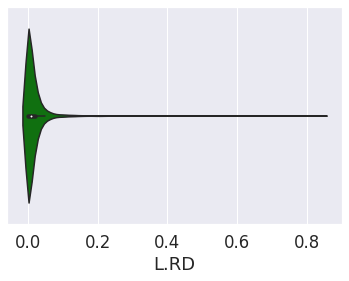

count    8145.000000
mean        0.018049
std         0.045042
min         0.000000
25%         0.000000
50%         0.009000
75%         0.020000
max         0.841000
Name: L.RD, dtype: float64
제1분위수: 0.0
제2분위수: 0.009000000000000001
제3분위수: 0.02
90%에 위치한 값: 0.04
IQR: 0.02
under_bound: [0]
upper_bound: 0.05


In [24]:
# L.RD의 데이터 확인
#plt.boxplot(origin_data.iloc[:, -4], vert=False)

df_LRD = origin_data.iloc[:, -4]

print("■ L.RD의 분포")
sns.set(font_scale = 1.5)
sns.violinplot(df_LRD, color='green')
plt.show()
print(df_LRD.describe())

# 이상치 구하기
# 확인
print("제1분위수:", df_LRD.quantile(0.25))
print("제2분위수:", df_LRD.quantile(0.50))
print("제3분위수:", df_LRD.quantile(0.75))
print("90%에 위치한 값:", df_LRD.quantile(0.9))

Q1 = df_LRD.quantile(0.25)
Q3 = df_LRD.quantile(0.75)
IQR = Q3 - Q1
print("IQR:", IQR)

arr=[Q1-1.5*IQR]
under_bound = [0 if x<0 else x for x in arr]
upper_bound = Q3 + 1.5*IQR
print("under_bound:", under_bound)
print("upper_bound:", upper_bound)

# 불량품/양품 기준
# 'L.RD' 0.05 이상이면 불량품, 미만이면 양품으로 결정함

■■■■■■■■■■■■■
■ Lambda 식에 대한 공부■
■■■■■■■■■■■■■

■ L.Vac의 분포


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


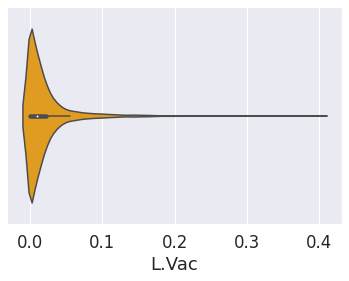

count    8145.000000
mean        0.019174
std         0.031836
min         0.000000
25%         0.000000
50%         0.010000
75%         0.022000
max         0.400000
Name: L.Vac, dtype: float64
0.0
0.01
0.022000000000000002
0.05


In [25]:
# L.Vac의 데이터 확인
df_LVac = origin_data.iloc[:, -3]

print("■ L.Vac의 분포")
sns.set(font_scale = 1.5)
sns.violinplot(df_LVac, color='orange')
plt.show()
print(df_LVac.describe())

print(df_LVac.quantile(0.25))
print(df_LVac.quantile(0.50))
print(df_LVac.quantile(0.75))
print(df_LVac.quantile(0.9))

### 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기

In [26]:
# 아무리봐도 피처는 아닌 것 같은 컬럼 제거하기
#print(fact_data_151_LRD.columns)
col_susang = ['투입.LEFT.', 'ROLLDOWN.폐기.LEFT.', '진공패드.폐기.LEFT.','ROLLDOWN.진공패드.폐기율..LEFT.']
col_use = []
for col in fact_data_150.columns:
    if col not in col_susang:
       col_use.append(col)
print(len(col_use)) # 146개

# 데이터프레임 만들기
fact_data_146 = fact_data[col_use]
fact_data_146

146


,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,Gross.width,Left.edge,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.C2..Z175.TMP.1TIC42307.PV,LIFT.OUT.ROL.MTR.M1.CUR.1WII40101.PV,LIFT.OUT.ROL.MTR.M2.CUR.1WII40102.PV,LEHR.DRV.MTR..M4.1.CUR.1WII40104.PV,LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV,LEHR.DRV.MTR..M7.1.CUR.1WII40110.PV,LEHR.DRV.MTR..M7.2.CUR.1WII40111.PV,LEHR.DRV.MTR..M8.1.CUR.1WII40112.PV,LEHR.DRV.MTR..M8.2.CUR.1WII40113.PV,LEHR.DRV.MTR..M10.2.CUR.1WII40117.PV,LEHR.DRV.MTR..M11.1.CUR.1WII40118.PV,LEHR.DRV.MTR..M12.1.CUR.1WII40120.PV,LEHR.DRV.MTR..M13.1.CUR.1WII40122.PV,LEHR.DRV.MTR..M15.1.CUR.1WII40126.PV,LEHR.DRV.MTR..M16.1.CUR.1WII40128.PV,LEHR.DRV.MTR..M16.2.CUR.1WII40129.PV,LEHR.DRV.MTR..M17.1.CUR.1WII40130.PV,LEHR.DRV.MTR..M18.1.CUR.1WII40132.PV,LEHR.DRV.MTR..M18.2.CUR.1WII40133.PV,LEHR.DRV.MTR..M19.1.CUR.1WII40134.PV,X1WOS45102_PV.1,X1WOS45106_PV.1,DCS_Offset_RPM_M11.1WOS45111_PV.1,DCS_Offset_RPM_M14.1WOS45114_PV.1,TMP.TIN..BAY.1.LEFT.1TI30201.PV,...,LOR.2.L.Hori,LOR.3.L.Axis,LOR.3.L.Hori,bay2_4,bay6_7,l_r_tin_bay10,lc_rc_btm_dn,c_btm_up_dn,l_r_top_n.1,top_1,top_5,D_AB1_L_LR,D_AB2_L_LR,D_AB3_L_LR,D_AB4_U_LR,D_AB5_U_LR,D_AB9_L_LR,D_AB10_U_LR,D_AB11_U_LR,D_AB11_L_LR,D_AB7_L_UL,D_AB8_L_UL,D_C1_U_LR,D_C3_U_LR,D_C4_U_LR,D_C4_L_LR,D_C2_L_UL,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB2_AB3_U_L,S_AB4_AB5_U_L,S_AB6_AB7_L_L,S_AB8_AB9_U_L,S_AB9_AB10_U_L,S_AB10_AB11_L_L,S_C1_C2_L_L,S_C3_C4_U_L
dat...date.name.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,-0.022694,3.027949,2.433864,1.290385,-1.994935,2.803512,2.180684,-0.011076,0.07524,0.01758,-0.02383,5.289937,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-0.911596,5.486833,5.271747,6.241618,0.054335,...,0.754759,0.367484,2.324515,1.386470,3.258018,0.069853,3.293793,0.843899,1.900728,2.707067,1.237408,0.143199,-0.264129,-1.785276,-0.464619,-0.866448,0.133905,1.183474,0.671758,2.048795,-0.414553,2.262545,1.014661,1.935018,0.878525,1.400976,1.264824,-0.331785,-0.336811,0.392527,-1.204339,0.022728,-1.047496,0.040088,-2.477830,1.012915,-0.398517,-1.277785,-0.195736,2.776941
2016-01-01 08,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,-0.022694,3.053693,2.392478,1.189370,-2.011604,2.808048,1.598043,-0.011076,0.07524,0.01758,-0.02383,4.508077,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,-0.133738,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.049592,...,0.079794,-0.050686,0.857440,1.417538,3.257741,0.102734,3.272101,0.882758,1.920147,2.753289,1.315761,0.164009,-0.229654,-1.734957,-0.426076,-0.885489,0.134373,1.194699,0.569452,2.015731,-0.302930,2.162538,0.978115,1.945713,0.765455,1.269891,1.253210,-0.201602,-0.023749,0.643118,-0.700142,-0.021609,-1.063102,0.030658,-2.508000,1.043599,-0.367705,-1.201661,-0.500742,2.888919
2016-01-01 09,0.126294,0.076956,0.076956,0.147152,-0.227141,-1.514135,-0.218748,0.048973,-3.879360,-2.296037,0.191359,-0.022694,3.079437,2.433864,1.041403,-2.104412,1.921064,1.598020,-0.011076,0.07524,0.01758,-0.02383,5.371871,-0.237516,-4.384738,-0.171091,-0.102056,-0.017896,0.858553,0.008717,0.015664,0.011076,2.421443,0.011076,1.531614,-1.570853,-0.098112,0.015846,-0.080082,0.062471,...,-0.328752,-0.410132,-0.717783,1.443347,3.259706,0.119169,3.211826,0.986665,1.717819,2.992712,1.790774,0.172756,-0.199157,-1.786606,-0.391402,-0.872139,0.247968,1.275461,0.585925,2.181967,-0.312238,2.205827,1.060357,1.989144,0.648465,1.058985,1.517443,-0.001965,

### 불량품/양품 컬럼 만들기

In [27]:
# 'L.RD' 0.05 이상이면 불량품, 미만이면 양품으로 결정함

df_LRD = origin_data.iloc[:, -4]
df_LRD[df_LRD.values >= 0.5] = 1
df_LRD[df_LRD.values != 1] = 0

print(df_LRD.unique())
print("■ 레이블 개수\n", df_LRD.value_counts())

[0. 1.]
■ 레이블 개수
 0.0    8128
1.0      17
Name: L.RD, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### ■ fact_data_LRD : 레이블을 L.RD로 쓰고 한글컬럼은 제외한 데이터

In [28]:
# 레이블 없는 데이터에 레이블 시리즈 합치기
fact_data_LRD = pd.concat([fact_data_146, df_LRD], axis=1)
print(fact_data_LRD.shape)

(8145, 147)


## 분류

In [29]:
from sklearn.model_selection import train_test_split

# 피처/레이블 데이터 나누기
X = fact_data_LRD.iloc[:, :-1]
y = fact_data_LRD.iloc[:, -1]

# 훈련/테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6108, 146)
(2037, 146)
(6108,)
(2037,)


In [30]:
# 의사결정나무 모델 사용
from sklearn.tree import DecisionTreeClassifier
# 모델 만들기
model_classifier = DecisionTreeClassifier()
# 훈련
model_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [31]:
# 예측
pred = model_classifier.predict(X_test)
print("예측값", pred[90:110])
print("레이블", y_test.values[90:110])

예측값 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
레이블 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


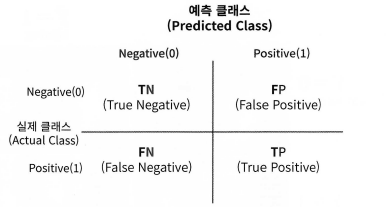

In [32]:
# 평가지표
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1.0 불량, 0.0 양품
print("■ 레이블 개수\n", df_LRD.value_counts())
print()
print("- confusion_matrix :\n", confusion_matrix(pred, y_test))
print("- accuracy_score :", accuracy_score(pred, y_test).round(3))
print("- precision_score :", precision_score(pred, y_test))
print("- recall_score :", recall_score(pred, y_test))
print("- f1_score :", f1_score(pred, y_test).round(3))
print("- roc_auc_score :", roc_auc_score(pred, y_test).round(3))

■ 레이블 개수
 0.0    8128
1.0      17
Name: L.RD, dtype: int64

- confusion_matrix :
 [[2029    2]
 [   3    3]]
- accuracy_score : 0.998
- precision_score : 0.6
- recall_score : 0.5
- f1_score : 0.545
- roc_auc_score : 0.75


# 산포도 그리기
* pca 주성분 2개로 산포도 그리기
* 원본 데이터 중 중요도가 높은 피처 2개로 산포도 그리기

In [33]:
# 스케일링
#fact_data_LRD
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(fact_data_LRD)
fact_data_scaled = scaler.transform(fact_data_LRD)

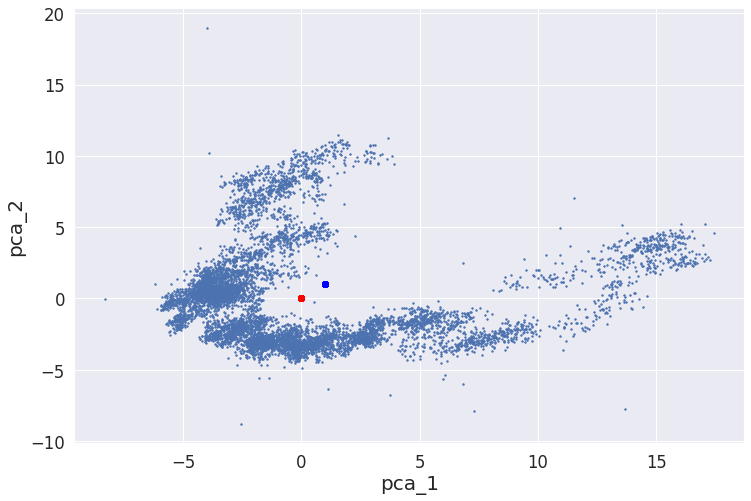

In [42]:
# PCA n_components=2로 수행
pca = PCA(n_components=2)
pca.fit(fact_data_scaled)
fact_data_pca = pca.transform(fact_data_scaled)

# 산포도 그리기
plt.figure(figsize=(12, 8))
plt.xlabel('pca_1', fontsize=20)
plt.ylabel('pca_2', fontsize=20)
plt.scatter(x=fact_data_pca[:, 0], y=fact_data_pca[:, 1], marker='o', s = 2)


colors=['red', 'blue']
for i , color in enumerate(colors):
    x_axis_data = fact_data_LRD.iloc[:, -1][fact_data_LRD.iloc[:, -1]==i]
    y_axis_data = fact_data_LRD[fact_data_LRD.iloc[:, -1]==i]['L.RD']
    plt.scatter(x_axis_data, y_axis_data , c=color)

In [44]:
fact_data_LRD.iloc[:, -1][fact_data_LRD.iloc[:, -1]==1]

dat...date.name.
2016-11-12 12    1.0
2016-11-13 13    1.0
2016-11-13 15    1.0
2016-11-13 16    1.0
2016-11-13 17    1.0
2016-11-13 18    1.0
2016-11-13 19    1.0
2016-11-18 16    1.0
2016-11-18 17    1.0
2016-11-19 03    1.0
2016-11-19 05    1.0
2016-11-19 06    1.0
2016-11-19 07    1.0
2016-11-26 23    1.0
2016-11-27 08    1.0
2016-11-27 10    1.0
2016-11-27 11    1.0
Name: L.RD, dtype: float64